In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import random

import pickle

from sklearn import preprocessing

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans

%matplotlib inline


from scipy.stats import ks_2samp

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import roc_auc_score

import eli5
from eli5.sklearn import PermutationImportance

import shap



/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
from importlib import reload
import logging

# ## activate logging ##
# reload(logging)
# logger = logging.getLogger()

## deactivate logger ##
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

Import created modules

In [74]:
from src.helpers import *

from src.cleaner import clean_data

from src.feature_selection import *

In [4]:
SEED = 0

# Load data

## Load sampled data

In [5]:
# logic to skip rows in read_csv: keep 1 out of 5, every 5th position

def logic(index):
    if index % 5 == 0:
        return False
    return True

In [6]:
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep = ';', skiprows= lambda x: logic(x))
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep = ';',skiprows= lambda x: logic(x) ) 

azdias.shape, customers.shape

Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.


((178244, 366), (38330, 369))

In [7]:
%%time

azdias = reduce_mem_usage(azdias)
customers = reduce_mem_usage(customers)

Mem. usage decreased to 115.42 Mb (76.8% reduction)
Mem. usage decreased to 25.44 Mb (76.4% reduction)
CPU times: user 20.5 s, sys: 13.6 s, total: 34.1 s
Wall time: 34.2 s


## Load original data

In [8]:
azdias_full = pd.read_csv('Udacity_AZDIAS_052018.csv', sep = ';')
customers_full = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep = ';') 

azdias_full.shape, customers_full.shape

((891221, 366), (191652, 369))

## Comparison between sampled and original

### Visual inspection

Variable: KBA13_BJ_2004


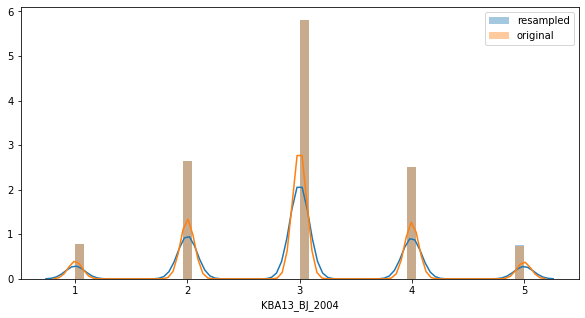


Variable: KBA13_FAB_ASIEN


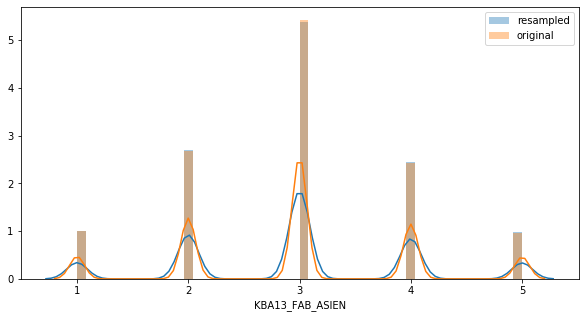


Variable: CJT_KATALOGNUTZER


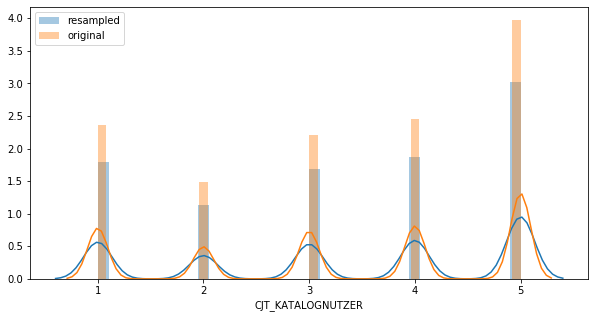


Variable: KBA05_CCM4


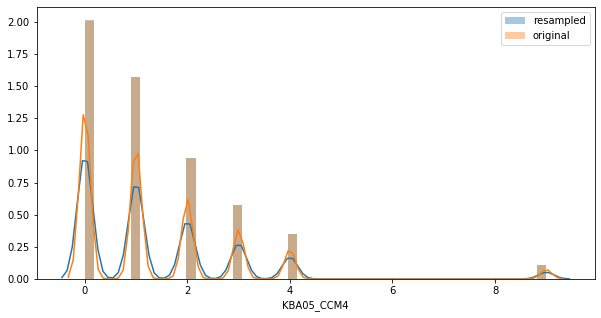


Variable: KBA13_KW_50


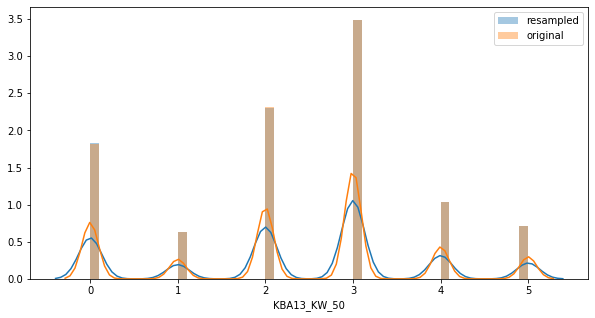

In [9]:
random.seed(SEED)
for i in random.sample(range(1, 366), 5):
    plt.figure(figsize = (10,5))
    variable = azdias.columns[i]
    print(f'Variable: {variable}')
    
    sns.distplot(azdias.iloc[:, i], label = 'resampled')
    sns.distplot(azdias_full.iloc[:,i], label = 'original')
    plt.legend()
    plt.show()
    print()

### KS test

KS test to compare two samples

In [10]:
numerical_columns, categorical_columns = var_lists(azdias)

In [11]:
for i in random.sample(range(1, 366), 10):
    variable = azdias.columns[i]
    
    p_val = ks_2samp(azdias.iloc[:, i], azdias_full.iloc[:,i]).pvalue
    print(f'Variable: {variable}; p-value: {p_val} ')
    print()

Variable: KBA13_KRSHERST_AUDI_VW; p-value: 0.6735909028777959 

Variable: KBA13_CCM_1500; p-value: 0.9845215421424507 

Variable: KBA05_MAXHERST; p-value: 0.8815667964800717 

Variable: KBA13_KMH_211; p-value: 0.9985040385071067 

Variable: KBA13_ALTERHALTER_30; p-value: 0.7006536766474607 

Variable: KBA13_VW; p-value: 0.567734071110832 

Variable: GEMEINDETYP; p-value: 0.9999999999864381 

Variable: KBA13_KW_121; p-value: 0.9995167095140515 

Variable: D19_TELKO_ANZ_24; p-value: 1.0 

Variable: KBA05_KRSHERST2; p-value: 0.9999923203096179 



In [12]:
for variable in numerical_columns:
    
    n_vars = 0
    p_val = ks_2samp(azdias.loc[:, variable], azdias_full.loc[:,variable]).pvalue
    try: 
        if (p_val.tolist()) < 0.05: 
            print(f'Variable: {variable}; p-value: {p_val} ')
            n_vars += 1
            
    except:
        print(f'\tSth wrong for {variable}')
        
print(f'Number of variables with different distributions: {n_vars}')

Number of variables with different distributions: 0


For all variables the 2-sampled KS test suggests that both distributions are similar.

## Data cleaning


In [13]:
%%time

azdias_clean = clean_data(azdias)

Initial df shape: (178244, 365)
Variables with missing values...
Your selected dataframe has 365 columns.
There are 273 columns that have missing values.
	Dropped 6 variables
Highly correlated variables...
	Dropped 63 variables
Constant variables
	Dropped 0 variables
Final df shape: (178244, 297)
CPU times: user 55.7 s, sys: 1.23 s, total: 56.9 s
Wall time: 57.1 s


In [14]:
%%time

customers_clean = clean_data(customers)
customers_clean.shape

Initial df shape: (38330, 368)
Variables with missing values...
Your selected dataframe has 368 columns.
There are 273 columns that have missing values.
	Dropped 5 variables
Highly correlated variables...
	Dropped 66 variables
Constant variables
	Dropped 0 variables
Final df shape: (38330, 301)
CPU times: user 13.3 s, sys: 256 ms, total: 13.5 s
Wall time: 13.5 s


(38330, 300)

In [15]:
final_vars = list(set(customers_clean.columns).intersection(set(azdias_clean.columns)))
len(final_vars)

285

# Dimensionality reduction

## Random Forest feature importance

-----

Let's train a RF classifier to detect which features are more important to that model


In [16]:
customer_f = customers_clean.copy()
azdias_f = azdias_clean.copy()
print(customer_f.shape, azdias_f.shape)
customer_f = customer_f[final_vars]
azdias_f = azdias_f[final_vars]

customer_f['Target'] = 1
azdias_f['Target'] = 0

both = pd.concat([azdias_f, customer_f], axis = 0)
both_resampled = both.sample(30000, random_state = SEED)
both.shape, both_resampled.shape

(38330, 300) (178244, 296)


((216574, 286), (30000, 286))

In [18]:
%%time

top_n = 20

X_train, X_test, y_train, y_test = split(both)

numerical_columns, categorical_columns = var_lists(both)

rf = create_pipe(categorical_columns, numerical_columns)

rf.fit(X_train, y_train)

CPU times: user 1min 24s, sys: 1.66 s, total: 1min 25s
Wall time: 1min 26s


Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='missing',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                        

In [19]:
feature_names = get_feats(rf, categorical_columns, numerical_columns)

tree_feature_importances = (
    rf.named_steps['classifier'].feature_importances_)


In [20]:
rf_importances_df = pd.DataFrame({'features': feature_names,
                     'importances': tree_feature_importances})\
                .sort_values('importances',ascending = False)\
                .reset_index(drop=True)
rf_importances_df[:top_n]

,features,importances
0,D19_SOZIALES,0.113217
1,D19_KONSUMTYP,0.040267
2,ALTERSKATEGORIE_GROB,0.029279
3,CJT_TYP_5,0.020892
4,CJT_TYP_6,0.018099
5,RT_SCHNAEPPCHEN,0.016406
6,ALTERSKATEGORIE_FEIN,0.014453
7,LP_STATUS_FEIN,0.014134
8,CJT_TYP_1,0.013288
9,HH_EINKOMMEN_SCORE,0.011990


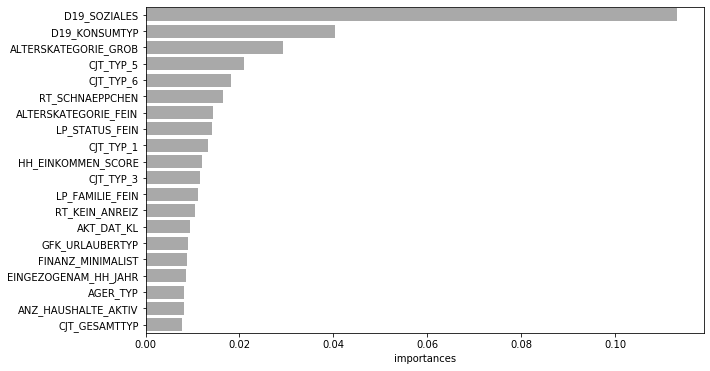

In [21]:
plt.subplots(figsize=(10,6))
sns.barplot(data = rf_importances_df[:top_n], x = 'importances', y = 'features', color = 'Darkgrey')
plt.ylabel('')
plt.show()

## Feature importances

-----
https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html

Here, we use this technique with the `pi_top` most important variables for the random forest model computed earlier.

In [22]:
pi_top = 30
pi_variables = rf_importances_df[:pi_top].features.tolist()

# pi_variables.extend(['Target'])
len(pi_variables)

30

In [23]:
# change train-test: reduce variables
numerical_columns.append('Target')
feats = get_feats(rf, categorical_columns, numerical_columns)
# feats = np.append(feats, 'Target')
both_resampled_new_vars = pd.DataFrame(rf['preprocess'].fit_transform(both_resampled), columns = feats)

# rf = create_pipe2(df, reduced_list)
# pi_variables.extend(['Target'])
pi_df = both_resampled_new_vars[pi_variables + ['Target']]

X_pi = pi_df.drop('Target', axis = 1)
y_pi = pi_df.Target

X_pi.shape, y_pi.shape

X_train_pi, X_test_pi, y_train_pi, y_test_pi = train_test_split(
    X_pi, y_pi, random_state=SEED)

In [24]:
# In this case, one categorical encoded column made it to the top 40 of the most important features

# we need to manually convert that variable to the original one, present in the initial df
# pi_variables.remove('OST_WEST_KZ_missing')

# pi_variables.append('OST_WEST_KZ')

In [25]:
numerical_columns_pi, categorical_columns_pi = var_lists(pi_df)

In [26]:
len(numerical_columns_pi), len(categorical_columns_pi)

(30, 0)

In [27]:
rf_pi = create_pipe(categorical_columns_pi, numerical_columns_pi)

In [28]:
rf_pi.fit(X_train_pi, y_train_pi)

Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='missing',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                        

In [29]:
%%time
result = permutation_importance(rf_pi, X_test_pi, y_test_pi, n_repeats=10,
                                random_state=SEED, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

CPU times: user 1.81 s, sys: 941 ms, total: 2.75 s
Wall time: 18.4 s


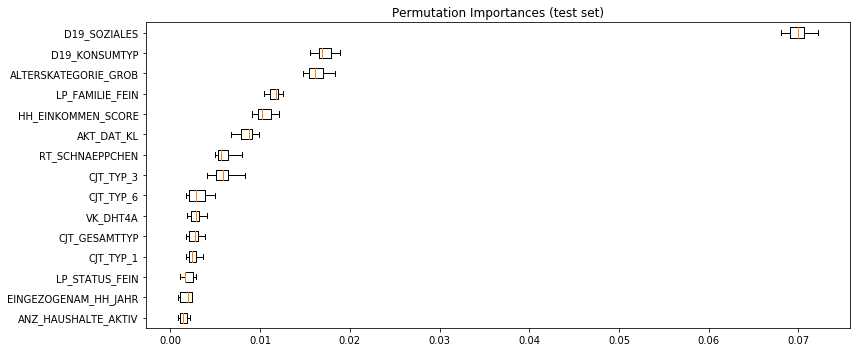

In [30]:
fig, ax = plt.subplots(figsize=(12,5))
ax.boxplot(result.importances[sorted_idx][-15:].T,
           vert=False, labels=X_test_pi.columns[sorted_idx][-15:])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

In [31]:
pi_variables = X_test_pi.columns[sorted_idx[::-1]][:15].to_list()
pi_variables 

['D19_SOZIALES',
 'D19_KONSUMTYP',
 'ALTERSKATEGORIE_GROB',
 'LP_FAMILIE_FEIN',
 'HH_EINKOMMEN_SCORE',
 'AKT_DAT_KL',
 'RT_SCHNAEPPCHEN',
 'CJT_TYP_3',
 'CJT_TYP_6',
 'VK_DHT4A',
 'CJT_GESAMTTYP',
 'CJT_TYP_1',
 'LP_STATUS_FEIN',
 'EINGEZOGENAM_HH_JAHR',
 'ANZ_HAUSHALTE_AKTIV']

## Model explainability

### eli5

In [32]:
X_train_r, X_test_r, y_train_r, y_test_r = split(both_resampled)

In [33]:
numerical_columns_r, categorical_columns_r = var_lists(both_resampled)

In [34]:
rf_r = create_pipe(categorical_columns_r, numerical_columns_r)
rf_r.fit(X_train_r, y_train_r)

Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='missing',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                        

In [35]:
X_train_tr = rf_r['preprocess'].fit_transform(X_train_r)
X_test_tr = rf_r['preprocess'].fit_transform(X_test_r)

In [36]:
feats = get_feats(rf_r, categorical_columns_r, numerical_columns_r)

In [38]:
X_train_tr.shape, X_test_tr.shape

((22500, 363), (7500, 363))

In [40]:
rf_r2 = create_num_pipe(numerical_columns_r)
rf_r2.fit(X_train_tr, y_train_r)

Pipeline(memory=None,
         steps=[('preprocess',
                 Pipeline(memory=None,
                          steps=[('imputer',
                                  SimpleImputer(add_indicator=False, copy=True,
                                                fill_value=None,
                                                missing_values=nan,
                                                strategy='median',
                                                verbose=0))],
                          verbose=False)),
                ('classifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
           

In [41]:
%%time

perm = PermutationImportance(rf_r2, random_state=SEED).fit(X_test_tr, y_test_r)

CPU times: user 5min 9s, sys: 3.88 s, total: 5min 13s
Wall time: 5min 13s


In [43]:
eli5.show_weights(perm, feature_names = feats)

Weight,Feature
0.0332 ± 0.0023,D19_SOZIALES
0.0172 ± 0.0031,D19_KONSUMTYP
0.0161 ± 0.0030,ALTERSKATEGORIE_GROB
0.0097 ± 0.0044,RT_SCHNAEPPCHEN
0.0074 ± 0.0025,LP_STATUS_FEIN
0.0067 ± 0.0025,CJT_GESAMTTYP
0.0063 ± 0.0026,ALTERSKATEGORIE_FEIN
0.0059 ± 0.0018,HH_EINKOMMEN_SCORE
0.0057 ± 0.0027,LP_FAMILIE_FEIN
0.0053 ± 0.0016,CJT_TYP_6


Important variables: D19_SOZIALES, ALTERSKATEGORIE_GROB, D19_KONSUMTYP

#### Select variables

In [44]:
%%time
# perm.feature_importances_ attribute is now available, it can be used
# for feature selection - let's e.g. select features which increase
# accuracy by at least threshold:
sel = SelectFromModel(perm, threshold=0.003, prefit=True)
X_train_reduced = sel.transform(X_train_tr)
X_test_reduced = sel.transform(X_test_tr)

CPU times: user 19.4 ms, sys: 2.98 ms, total: 22.3 ms
Wall time: 20.4 ms


In [45]:
X_test_reduced.shape, X_test_tr.shape

((7500, 20), (7500, 363))

In [46]:
most_important_variables = np.array(feats)[sel.get_support()].tolist()
most_important_variables

['OST_WEST_KZ_W',
 'OST_WEST_KZ_missing',
 'CAMEO_DEU_2015_missing',
 'CJT_KATALOGNUTZER',
 'HEALTH_TYP',
 'AKT_DAT_KL',
 'GEBURTSJAHR',
 'CJT_GESAMTTYP',
 'CJT_TYP_6',
 'HH_EINKOMMEN_SCORE',
 'LP_STATUS_FEIN',
 'CJT_TYP_5',
 'CJT_TYP_3',
 'ALTERSKATEGORIE_FEIN',
 'LP_FAMILIE_FEIN',
 'CJT_TYP_1',
 'ALTERSKATEGORIE_GROB',
 'D19_KONSUMTYP',
 'D19_SOZIALES',
 'RT_SCHNAEPPCHEN']

In [47]:
len(most_important_variables)

20

### Shap

In [48]:
rf_model = RandomForestClassifier(random_state=SEED)

X_train_tr = pd.DataFrame(rf_r['preprocess'].fit_transform(X_train_r), columns = feats)
X_test_tr = pd.DataFrame(rf_r['preprocess'].fit_transform(X_test_r), columns = feats)

rf_model.fit(X_train_tr, y_train_r)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [49]:
explainer = shap.TreeExplainer(rf_model)


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [50]:
%%time
# calculate shap values. This is what we will plot.
shap_values = explainer.shap_values(X_test_tr, check_additivity=False)

CPU times: user 17min 25s, sys: 2.32 s, total: 17min 28s
Wall time: 17min 26s


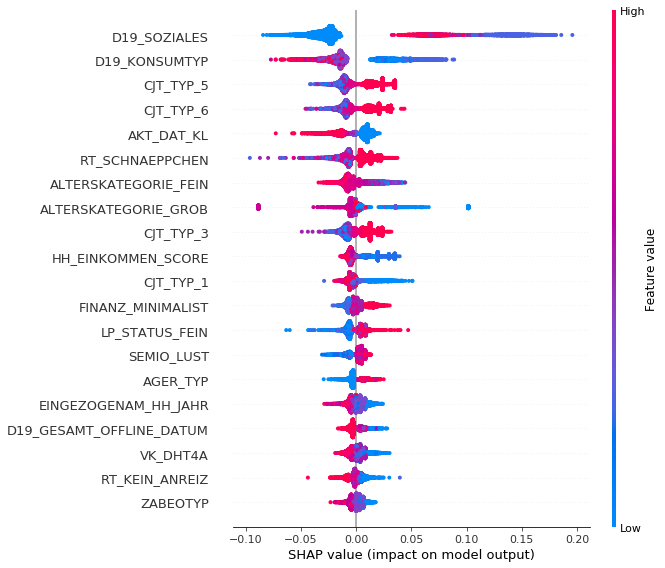

In [51]:
# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1], X_test_tr)

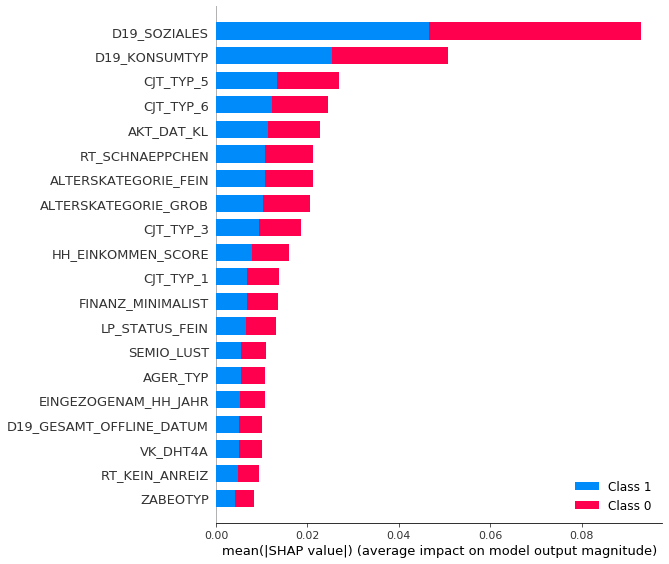

In [52]:
shap.summary_plot(shap_values, X_test_tr, plot_type='bar')

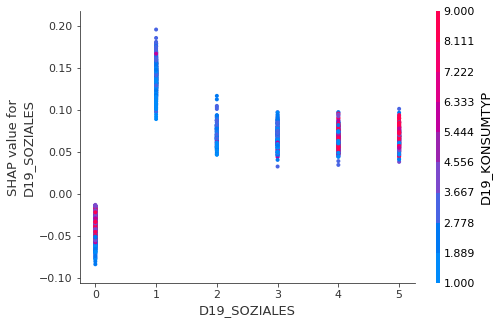

In [53]:
# make plot.
shap.dependence_plot('D19_SOZIALES', shap_values[1], X_test_tr, interaction_index="D19_KONSUMTYP")

## Variable reduction effect in model's performance

In [59]:
test_vars = rf_importances_df[:10].features.tolist()
test_vars

['D19_SOZIALES',
 'D19_KONSUMTYP',
 'ALTERSKATEGORIE_GROB',
 'CJT_TYP_5',
 'CJT_TYP_6',
 'RT_SCHNAEPPCHEN',
 'ALTERSKATEGORIE_FEIN',
 'LP_STATUS_FEIN',
 'CJT_TYP_1',
 'HH_EINKOMMEN_SCORE']

In [61]:
%%time

test_performance(both_resampled, most_important_variables)
print()

Pipeline completed. Model ROC-AUC: 0.729.
Model with 20 variables succesfully trained. Final ROC-AUC: 0.808

CPU times: user 10.8 s, sys: 541 ms, total: 11.3 s
Wall time: 11.4 s


In [62]:
%%time

results = []
for i in range(10,200,10):
    print()
    print(i)
    test_vars = rf_importances_df[:i].features.tolist() # take the first i variables
    result = test_performance(both_resampled,  test_vars)
    print(result)
    results.append(result)

print()


10
Pipeline completed. Model ROC-AUC: 0.729.
Model with 10 variables succesfully trained. Final ROC-AUC: 0.795
0.7950362695109667

20
Pipeline completed. Model ROC-AUC: 0.729.
Model with 20 variables succesfully trained. Final ROC-AUC: 0.811
0.8106582193973562

30
Pipeline completed. Model ROC-AUC: 0.729.
Model with 30 variables succesfully trained. Final ROC-AUC: 0.796
0.7958981096127867

40
Pipeline completed. Model ROC-AUC: 0.729.
Model with 40 variables succesfully trained. Final ROC-AUC: 0.794
0.7938821065207038

50
Pipeline completed. Model ROC-AUC: 0.729.
Model with 50 variables succesfully trained. Final ROC-AUC: 0.797
0.7974565956632752

60
Pipeline completed. Model ROC-AUC: 0.729.
Model with 60 variables succesfully trained. Final ROC-AUC: 0.786
0.7862185130671747

70
Pipeline completed. Model ROC-AUC: 0.729.
Model with 70 variables succesfully trained. Final ROC-AUC: 0.789
0.7886110221833544

80
Pipeline completed. Model ROC-AUC: 0.729.
Model with 80 variables succesfully t

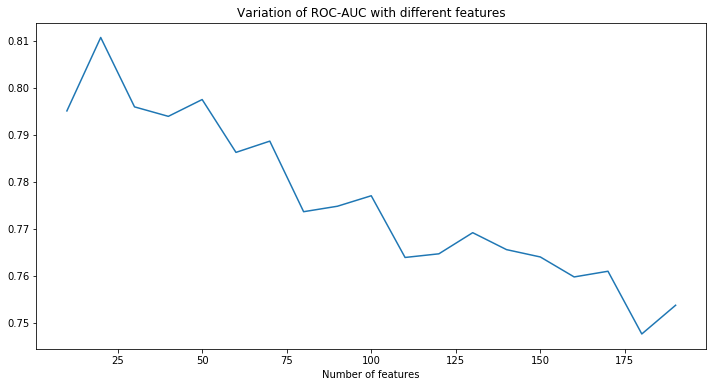

In [63]:
plt.figure(figsize=(12,6))
plt.plot(range(10,200,10), results)
plt.xlabel('Number of features')
plt.ylabel('')
plt.title('Variation of ROC-AUC with different features')
plt.show()

The optimal number of features to take from RF is around 20.

In [64]:
best_features_RF = rf_importances_df[:20].features.tolist()
best_features_RF

['D19_SOZIALES',
 'D19_KONSUMTYP',
 'ALTERSKATEGORIE_GROB',
 'CJT_TYP_5',
 'CJT_TYP_6',
 'RT_SCHNAEPPCHEN',
 'ALTERSKATEGORIE_FEIN',
 'LP_STATUS_FEIN',
 'CJT_TYP_1',
 'HH_EINKOMMEN_SCORE',
 'CJT_TYP_3',
 'LP_FAMILIE_FEIN',
 'RT_KEIN_ANREIZ',
 'AKT_DAT_KL',
 'GFK_URLAUBERTYP',
 'FINANZ_MINIMALIST',
 'EINGEZOGENAM_HH_JAHR',
 'AGER_TYP',
 'ANZ_HAUSHALTE_AKTIV',
 'CJT_GESAMTTYP']

Test with `pi_variables`

In [66]:
test_performance(both_resampled,  most_important_variables)

Pipeline completed. Model ROC-AUC: 0.729.
Model with 20 variables succesfully trained. Final ROC-AUC: 0.808


0.807646171204585

Test with the whole dataset and `best_features_RF`

In [67]:
%%time 

test_performance(both, best_features_RF)

Pipeline completed. Model ROC-AUC: 0.771.
Model with 20 variables succesfully trained. Final ROC-AUC: 0.823
CPU times: user 1min 49s, sys: 3.89 s, total: 1min 53s
Wall time: 1min 53s


0.8233649904175033

## Save the datasets

Save as a dict with the most important variables from each method

{data: 'azdias.clean', most_important_RF: , permutation_importance: ,

In [69]:
clean_data_dict = {'azdias_data': azdias_clean, 'customers_data': customers_clean, 'RF_vars': best_features_RF,
                  'eli5_vars': most_important_variables}


In [72]:
with open('data/clean_data.pickle', 'wb') as handle:
    pickle.dump(clean_data_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)